# Предсказание успешности стартапа

## Постановка задачи

Требуется подготовить прототип модели машинного обучения, которая должна предсказать успешность стартапа (закроется или нет). Модель поможет выявить стартапы, которые могут закрыться в ближайщее время.

## Данные

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - `1970-01-01` по `2018-01-01`. Дата формирования выгрузки - `2018-01-01`

`startups_train.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
`startups_test.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. В тестовом наборе нет целевых признаков.

`name` - идентификатор (название) стартапа в тестовом наборе.
`status` - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

## Описание полей данных
`name` - Название стартапа
`category_list` - Список категорий, к которым относится стартап
`funding_total_usd` - Общая сумма финансирования в USD
`status` - Статус стартапа (закрыт или действующий)
`country_code` - Код страны
`state_code` - Код штата
`region` - Регион
`city` - Город
`funding_rounds` - Количество раундов финансирования
`founded_at` - Дата основания
`first_funding_at` - Дата первого раунда финансирования
`last_funding_at` - Дата последнего раунда финансирования
`closed_at` - Дата закрытия стартапа (если применимо)

## План работы:
- загрузить библиотеки;
- открыть файлы с данными;
- выполнить предобработку данных:
    - изменить типы данных там где это необходимо;
    - проверить и устранить дубликаты;
    - проверить наличие пропущенных значений;  
- провести исследовательский анализ данных:
    - найти аномальные и выдающиеся значения;
    - выбрать данные для обучения.
- выполнить корреляционный анализ;
- используя пайплайны найти лучшие гиперпараметры модели;
- выполнить анализ важности признаков;
- выбрать лучшую модель и проверить её на тестовой выборке;
- описать выводы.

## Загрузка библиотек

Установим необходимые библиотеки:

In [90]:
!pip install shap scikit-learn catboost optuna phik imbalanced-learn seaborn==0.11.1

Импортируем необходимые библиотеки

In [91]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from scipy import stats
from optuna import visualization
from sklearn.cluster import KMeans
from phik.report import plot_correlation_matrix
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import classification_report, make_scorer, f1_score
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

Необходимые библиотеки загружены.

## Загрузка данных

Откроем файл `startups_train.csv` он содержит данные о стартапах для обучения:

In [92]:
startups_train_df = pd.read_csv('datasets/startups_train.csv', sep=',', decimal='.')
startups_train_df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN


Посмотрим на общию информацию о таблице:

In [93]:
startups_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Откроем файл `startups_test.csv` он содержит данные о тестовом наборе:

In [94]:
startups_test_df = pd.read_csv('datasets/startups_test.csv', sep=',', decimal='.')
startups_test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN


Посмотрим на общию информацию о таблице:

In [95]:
startups_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


Загрузили необходимые таблицы, данные в таблицах соответствуют описанию. Выполним предобработку данных. Необходимо проверить таблицы на дубликаты, пропуски, изменить типы данных. Проведем предобработку данных.

## Предобработка данных

Уберем колонку `name` так как не будем использовать её при обучении:

In [96]:
startups_train_df = startups_train_df.drop(['name'], axis=1)

Напишем вспомогательные функции которые будем использовать при предобработке:

In [97]:
def isna_rate(df):
    """Выводит на экран количество пропусков
        
    Args:
        df: датафрейм в котором берутся колонки
    Returns:
        Ничего.
    """
    isna_df = (pd.DataFrame(round(df.isna().mean() * 100, 2)).sort_values(by=0, ascending=False))
    isna_df.columns = ['Процент пропусков']
    display(isna_df.query('`Процент пропусков` > 0').style.format(precision=2).background_gradient('coolwarm'))


def check_duplicated(df):
    """Проверяет на дубликаты датафрейм в случаи отсутствия выводит строку Дубликаты отсутсвуют.

    Args:
        df: датафрейм в котором проходит проверка
    Returns:
        Ничего.
    """
    # проверка на дубликаты
    duplicates = df.apply(lambda x: x.astype(str).str.lower().str.strip()).duplicated()
    duplicates_count = duplicates.sum()
    print("Количество дубликатов:", duplicates_count)
    if duplicates_count > 0:
        display(df[duplicates])
    else:
        print("Дубликаты отсутствуют.")

### Пропуски

Проверим наличие пропусков в `startups_train_df`

In [98]:
isna_rate(startups_train_df)

,Процент пропусков
closed_at,90.62
funding_total_usd,19.15
state_code,12.85
region,12.08
city,12.08
country_code,10.45
category_list,4.74
first_funding_at,0.04


Посмотрим данные в колонке `first_funding_at`:

In [99]:
startups_train_df.query("first_funding_at.isna()")

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1738,Consumer Electronics|Design|E-Commerce|Hardwar...,NaN,operating,NaN,NaN,NaN,NaN,2,2014-01-01,NaN,2014-10-01,NaN
2353,Bitcoin|Payments,1.250000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2014-02-01,NaN,2015-11-17,NaN
4325,Big Data Analytics|Hardware + Software|Health ...,2.000000e+04,operating,USA,MA,Boston,Boston,3,2010-01-01,NaN,2012-06-01,NaN
4327,Commercial Real Estate|Marketing Automation|Ma...,8.000000e+06,operating,USA,TX,Austin,Austin,2,2013-02-11,NaN,2015-05-14,NaN
4661,Customer Service|Logistics|Transportation,4.349586e+06,operating,BRA,2,Sao Paulo,São Paulo,5,2013-01-01,NaN,2015-01-23,NaN
5811,Analytics|Application Platforms|Business Analy...,2.725000e+05,operating,USA,MI,Detroit,Detroit,4,2015-02-01,NaN,2015-06-14,NaN
6253,Financial Services,1.675551e+06,operating,GBR,H9,London,London,3,2014-01-04,NaN,2014-09-01,NaN
13578,Education|Mobility|Online Education|Software,3.040120e+05,operating,FIN,13,Helsinki,Helsinki,2,2012-02-08,NaN,2014-04-24,NaN
15105,Wearables,3.320000e+06,operating,USA,CO,Denver,Denver,3,2013-01-01,NaN,2015-11-26,NaN
16165,Curated Web|Education|Knowledge Management|Nat...,1.500000e+05,operating,USA,CA,SF Bay Area,San Francisco,2,2009-01-01,NaN,2011-03-18,NaN


Удалим данные, так их мало (0.04% от общего количества)

In [100]:
startups_train_df = startups_train_df.dropna(subset=['first_funding_at'])

Посмотри данные о местоположении:

In [101]:
startups_train_df.query("country_code.isna()")

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
12,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaN
15,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaN
16,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaN


Оставим пропуска как есть так их достаточно много (>5000)

Посмотрим на данные где `country_code` заполнен а `state_code` не заполнен:

In [102]:
startups_train_df.query("~country_code.isna() and state_code.isna()")

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
51,Travel,850000.0,operating,AUS,NaN,NaN,NaN,1,2014-01-01,2015-06-01,2015-06-01,NaN
106,Mobile,374000000.0,closed,USA,NaN,NaN,NaN,4,2004-01-08,2005-08-08,2007-03-21,2008-10-28
301,Analytics|Big Data|Business Intelligence|Desig...,560000.0,operating,SGP,NaN,Singapore,Singapore,1,2012-10-01,2013-09-01,2013-09-01,NaN
326,Application Platforms|mHealth|Tracking,50000.0,closed,RUS,NaN,NaN,NaN,1,2011-06-04,2012-02-01,2012-02-01,2013-09-23
346,Curated Web,8130000.0,operating,CHN,NaN,NaN,NaN,1,2014-03-31,2014-03-23,2014-03-23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
52694,Education|Software,NaN,operating,USA,NaN,NaN,NaN,1,2009-07-07,2010-04-12,2010-04-12,NaN
52725,Software,7500000.0,operating,SGP,NaN,Singapore,Singapore,1,2007-05-24,2009-02-11,2009-02-11,NaN
52745,Apps|Software|Software Compliance,12000000.0,operating,HKG,NaN,HKG - Other,Yuen Long,2,2012-07-21,2014-03-20,2014-06-04,NaN
52770,Games,429420.0,operating,MLT,NaN,Malta,Valletta,1,2009-09-01,2009-09-01,2009-09-01,NaN


Оставим как есть, есть страны в которых отсутствует state_code.

Преобразуем тип данных в дату в колонках с датой:

In [103]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in date_columns:
    startups_train_df[col] = pd.to_datetime(startups_train_df[col])

Посмотрим описательную статистику для этих столбцов:

In [104]:
startups_train_df[date_columns].describe()

,founded_at,first_funding_at,last_funding_at,closed_at
count,52858,52858,52858,4962
mean,2008-05-09 18:31:49.992811008,2011-07-16 01:49:32.598281984,2012-06-26 17:21:21.365166848,2012-01-05 17:08:11.898428160
min,1749-01-01 00:00:00,1960-01-01 00:00:00,1971-01-01 00:00:00,1972-09-06 00:00:00
25%,2006-07-07 00:00:00,2009-10-10 00:00:00,2011-02-01 00:00:00,2009-09-25 06:00:00
50%,2010-09-02 00:00:00,2012-07-25 00:00:00,2013-08-31 00:00:00,2012-09-02 12:00:00
75%,2012-12-26 00:00:00,2014-04-01 00:00:00,2014-11-16 00:00:00,2015-04-17 18:00:00
max,2105-02-17 00:00:00,2015-12-05 00:00:00,2115-12-01 00:00:00,2106-07-20 00:00:00


Есть данные вне границ `1970-01-01` по `2018-01-01`, посмотрим сколько их:

In [105]:
temp_df = startups_train_df[(startups_train_df['founded_at'] < '1970-01-01') |
                                   (startups_train_df['founded_at'] > '2018-01-01') |
                                   (startups_train_df['first_funding_at'] < '1970-01-01') |
                                   (startups_train_df['first_funding_at'] > '2018-01-01') |
                                   (startups_train_df['last_funding_at'] < '1970-01-01') |
                                   (startups_train_df['last_funding_at'] > '2018-01-01') |
                                   (startups_train_df['closed_at'] < '1970-01-01') |
                                   (startups_train_df['closed_at'] > '2018-01-01')]
temp_df

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
48,NaN,NaN,operating,USA,CA,Los Angeles,Culver City,1,1948-01-01,2014-11-24,2014-11-24,NaT
317,Hospitality,9000000.0,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,NaT
404,NaN,NaN,operating,KHM,11,Phnom Penh,Phnom Penh,1,1960-01-01,2012-04-01,2012-04-01,NaT
650,Pharmaceuticals,75000.0,operating,USA,ME,ME - Other,Bar Harbor,1,1898-01-01,2015-07-16,2015-07-16,NaT
1120,Consulting,7500000.0,operating,USA,CA,San Diego,San Diego,1,1968-01-01,2009-06-08,2009-06-08,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
51474,Automotive|Electronics|Systems|Technology,84000000.0,operating,USA,MI,Detroit,Troy,1,1963-01-01,2012-07-09,2012-07-09,NaT
51730,Health and Wellness,2200000.0,operating,USA,KS,KS - Other,Coffeyville,1,1961-01-01,2014-01-09,2014-01-09,NaT
51935,Hardware + Software,NaN,operating,JPN,22,Kyoto,Kyoto-shi,1,1854-02-01,1995-01-01,1995-01-01,NaT
52278,E-Commerce|Fashion|Jewelry,100000.0,operating,USA,NY,Long Island,Garden City,1,1910-01-01,2007-01-01,2007-01-01,NaT


Удалим их так как их мало:

In [106]:
startups_train_df.drop(temp_df.index, inplace=True)
startups_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52553 entries, 0 to 52878
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category_list      50088 non-null  object        
 1   funding_total_usd  42474 non-null  float64       
 2   status             52553 non-null  object        
 3   country_code       47043 non-null  object        
 4   state_code         45779 non-null  object        
 5   region             46185 non-null  object        
 6   city               46185 non-null  object        
 7   funding_rounds     52553 non-null  int64         
 8   founded_at         52553 non-null  datetime64[ns]
 9   first_funding_at   52553 non-null  datetime64[ns]
 10  last_funding_at    52553 non-null  datetime64[ns]
 11  closed_at          4945 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(6)
memory usage: 5.2+ MB


In [107]:
startups_train_df[date_columns].describe()

,founded_at,first_funding_at,last_funding_at,closed_at
count,52553,52553,52553,4945
mean,2008-11-01 19:16:43.763819264,2011-07-16 09:38:07.907445760,2012-06-26 17:26:41.240652288,2012-01-09 01:16:17.714863616
min,1970-01-01 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-11-21 00:00:00
25%,2006-09-24 00:00:00,2009-10-09 00:00:00,2011-02-01 00:00:00,2009-09-28 00:00:00
50%,2010-10-01 00:00:00,2012-07-19 00:00:00,2013-08-30 00:00:00,2012-09-05 00:00:00
75%,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-18 00:00:00
max,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-11-06 00:00:00


В данных есть ошибки когда дата создания стартапа позже даты первого финансирования:

In [108]:
 startups_train_df[startups_train_df['founded_at'] > startups_train_df['first_funding_at']]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
34,Entertainment|Games,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,2013-08-13,2013-07-09,2013-07-09,NaT
75,Fashion|Retail,389454.0,operating,NaN,NaN,NaN,NaN,2,2014-04-01,2013-12-09,2014-09-09,NaT
97,Healthcare Services|Medical Devices|Technology,18400000.0,closed,USA,NY,New York City,New York,2,2005-11-01,2005-10-10,2007-04-25,2008-07-24
111,Collaboration|Enterprise Software|Project Mana...,1400000.0,operating,USA,CA,SF Bay Area,San Francisco,2,2009-10-09,2009-09-09,2011-01-01,NaT
114,3D|3D Printing|DIY|E-Commerce|Mass Customizati...,1000000.0,operating,USA,TX,Houston,Cypress,2,2011-08-01,2006-04-01,2011-08-09,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
52728,Curated Web,450000.0,closed,USA,CA,SF Bay Area,Santa Clara,1,2007-02-01,2007-01-01,2007-01-01,2008-06-15
52737,Health Care,7000000.0,operating,NaN,NaN,NaN,NaN,1,2014-10-01,2014-09-23,2014-09-23,NaT
52790,Android|iOS|iPhone|Mobile|Social Media|Teenagers,15200000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2013-11-12,2013-11-01,2015-09-08,NaT
52804,E-Commerce,NaN,operating,DEU,16,Berlin,Berlin,2,2011-10-01,2011-01-01,2012-02-01,NaT


Удалим их:

In [109]:
 startups_train_df = startups_train_df[
    startups_train_df['founded_at'] <= startups_train_df['first_funding_at']]

Добавим новые колонки и удалим старые:

In [110]:
def add_new_time_columns(df):
    # 1. Время от основания до первого раунда финансирования в днях
    df['time_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days

    # 2. Время между первым и последним раундами финансирования в днях
    df['time_between_funding_rounds'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

    # 3. Время от последнего раунда финансирования до даты основания, в днях
    df['total_funding_time'] = (df['last_funding_at'] - df['founded_at']).dt.days

    # 3. Время от последнего раунда финансирования до даты основания, в днях
    df['total_funding_time'] = (df['last_funding_at'] - df['founded_at']).dt.days

    # 4. Количество дней на раунд
    df['funding_day'] = (df['total_funding_time'] / df['funding_rounds'])

    # 5. Время жизни стартапа
    df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days

    df = df.drop(columns=date_columns, axis=1)
    return df


#startups_train_df.closed_at = pd.to_datetime('2018-01-01')
startups_train_df.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)
startups_train_df = add_new_time_columns(startups_train_df)
startups_train_df

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,time_to_first_funding,time_between_funding_rounds,total_funding_time,funding_day,lifetime
0,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,311,1310,1621,810.500000,2748
1,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,1949,1393,3342,835.500000,4748
2,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2423,681,3104,1034.666667,4383
3,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2800,1051,3851,1283.666667,5114
4,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,551,0,551,551.000000,2712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52873,News,205600000.0,operating,CHN,23,Shanghai,Shanghai,2,2661,2606,5267,2633.500000,6209
52874,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,790,0,790,790.000000,2192
52875,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,320,0,320,320.000000,1716
52877,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,364,1918,2282,380.333333,7336


Посмотрим текущие пропуски:

In [111]:
isna_rate(startups_train_df)

,Процент пропусков
funding_total_usd,19.02
state_code,12.91
region,12.19
city,12.19
country_code,10.51
category_list,4.79


Заполним пропуски в `funding_total_usd` и `category_list` используя KMeans для поиска похожих стартапов, в `category_list` заполним значение модой, а в `funding_total_usd` средним значенинием:

In [112]:
def set_missed(df):
    copy_df = df.copy()

    # Выбор признаков для кластеризации
    features = ['funding_rounds', 'time_to_first_funding', 'time_between_funding_rounds', 'total_funding_time',
                'funding_day', 'lifetime']

    # Масштабирование признаков
    scaler = StandardScaler()
    copy_df[features] = scaler.fit_transform(copy_df[features])

    # Применение алгоритма K-Means
    kmeans = KMeans(n_clusters=10, random_state=42)
    copy_df['cluster'] = kmeans.fit_predict(df[features])

    # Функция для заполнения пропущенных значений на основе похожих стартапов
    def fill_missing_values(row):
        if pd.isnull(row['category_list']):
            cluster_data = copy_df[copy_df['cluster'] == row['cluster']]
            row['category_list'] = cluster_data['category_list'].mode()[0]

        if pd.isnull(row['funding_total_usd']):
            cluster_data = copy_df[copy_df['cluster'] == row['cluster']]
            row['funding_total_usd'] = cluster_data['funding_total_usd'].mean()

        return row

    copy_df = copy_df.apply(fill_missing_values, axis=1)
    df['category_list'] = copy_df['category_list']
    df['funding_total_usd'] = copy_df['funding_total_usd']
    


In [113]:
set_missed(startups_train_df)

Добавим колонку с количеством финансирования в раунде

In [114]:
# 6. Количество финансирования в раунде
startups_train_df['funding_per_round'] = (
            startups_train_df['funding_total_usd'] / startups_train_df['funding_rounds'])

Проверим итоговое количество пропусков:

In [115]:
isna_rate(startups_train_df)
startups_train_df.info()

,Процент пропусков
state_code,12.91
region,12.19
city,12.19
country_code,10.51


<class 'pandas.core.frame.DataFrame'>
Index: 49592 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   category_list                49592 non-null  object 
 1   funding_total_usd            49592 non-null  float64
 2   status                       49592 non-null  object 
 3   country_code                 44382 non-null  object 
 4   state_code                   43188 non-null  object 
 5   region                       43549 non-null  object 
 6   city                         43549 non-null  object 
 7   funding_rounds               49592 non-null  int64  
 8   time_to_first_funding        49592 non-null  int64  
 9   time_between_funding_rounds  49592 non-null  int64  
 10  total_funding_time           49592 non-null  int64  
 11  funding_day                  49592 non-null  float64
 12  lifetime                     49592 non-null  int64  
 13  funding_per_round    

### Дубликаты

Проверим на явные дубликаты

In [116]:
check_duplicated(startups_train_df)

Количество дубликатов: 8


,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,time_to_first_funding,time_between_funding_rounds,total_funding_time,funding_day,lifetime,funding_per_round
6591,Software,7.278651e+06,operating,KOR,11,Seoul,Seoul,1,516,0,516,516.0,1461,7.278651e+06
25264,Software,7.278651e+06,operating,NaN,NaN,NaN,NaN,1,0,0,0,0.0,1461,7.278651e+06
30129,Software,7.278651e+06,operating,NaN,NaN,NaN,NaN,1,0,0,0,0.0,1096,7.278651e+06
39163,Software,7.278651e+06,operating,NaN,NaN,NaN,NaN,1,365,0,365,365.0,1826,7.278651e+06
43627,Software,7.278651e+06,operating,NaN,NaN,NaN,NaN,1,0,0,0,0.0,1461,7.278651e+06
46002,Software,7.278651e+06,operating,NaN,NaN,NaN,NaN,1,91,0,91,91.0,2192,7.278651e+06
48103,Software,7.278651e+06,operating,USA,CA,SF Bay Area,Palo Alto,1,14,0,14,14.0,1461,7.278651e+06
52302,Advertising,2.500000e+04,operating,ARG,7,Buenos Aires,Buenos Aires,1,578,0,578,578.0,2557,2.500000e+04


Данные дубликаты не принесут ценности для модели, удалим их:

In [117]:
startups_train_df = startups_train_df.drop_duplicates()

In [118]:
startups_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49584 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   category_list                49584 non-null  object 
 1   funding_total_usd            49584 non-null  float64
 2   status                       49584 non-null  object 
 3   country_code                 44379 non-null  object 
 4   state_code                   43185 non-null  object 
 5   region                       43546 non-null  object 
 6   city                         43546 non-null  object 
 7   funding_rounds               49584 non-null  int64  
 8   time_to_first_funding        49584 non-null  int64  
 9   time_between_funding_rounds  49584 non-null  int64  
 10  total_funding_time           49584 non-null  int64  
 11  funding_day                  49584 non-null  float64
 12  lifetime                     49584 non-null  int64  
 13  funding_per_round    

В процессе предобработки данных мы удалили строки с пропусками, заполнили пропуски, добавили новые колонки для заполнения пропусков, изменили типы данных, удалили дубликаты.

## Исследовательском анализ

Напишем вспомогательные функции которые будем использовать при исследовательском анализе:

In [119]:
def column_quantitative_info(df, column):
    # для количественного признака
    desc = df[column].describe()
    print(desc)

    if df[column].dtype == 'int64':
        n_bins = (df[column].max() - df[column].min()) + 1
        if n_bins > 100:
            binwidth = None
            discrete = False
            bins = 'auto'
        else:
            bins = n_bins
            discrete = True
            binwidth = 1
    else:
        binwidth = None
        discrete = False
        bins = 'auto'

    print(discrete, bins)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    sns.histplot(data=df[column], kde=False, ax=axes[0], discrete=discrete, binwidth=binwidth, bins=bins)
    axes[0].axvline(df[column].mean(), color='red', linestyle='--', label='Mean')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Частота')
    axes[0].set_xlabel(column)
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_ylabel('Значение')
    stats.probplot(df[column], plot=sns.mpl.pyplot, dist="norm")
    axes[2].set_title('Q-Q график')
    axes[2].set_ylabel('Квантили эмпирических данных')
    axes[2].set_xlabel('Теоретические квантили')
    plt.show()


def quantitative_info(df):
    # для количественного признака
    for column in df.select_dtypes(include='number').columns.tolist():
        print(f'Колонка: \'{column}\':')
        column_quantitative_info(df, column)


def categorical_info(df):
    # для категориального признака
    for column in df.loc[:, df.columns != 'id'].select_dtypes(include='object').columns.tolist():
        print(f'Колонка: \'{column}\':')
        print((df[column].describe()))
        df[column].value_counts().plot(title=column, autopct='%1.1f%%', kind='pie', figsize=(7, 7))
        plt.ylabel(f"Соотношение {column}")
        plt.show()

Получим информацию для количественных признаков:

Колонка: 'funding_total_usd':
count    4.958400e+04
mean     1.713185e+07
std      1.706978e+08
min      1.000000e+00
25%      5.900000e+05
50%      4.500000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64
False auto


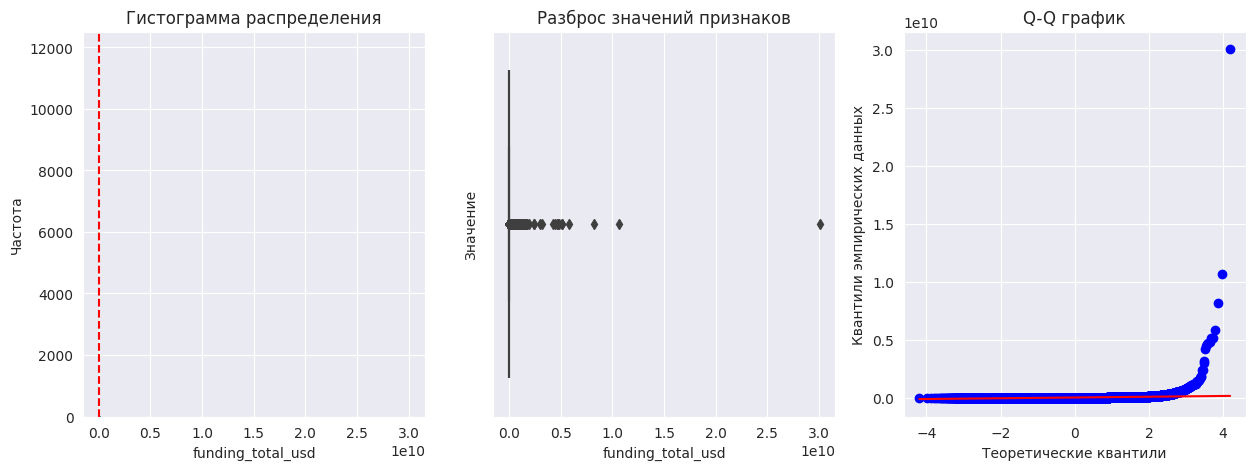

Колонка: 'funding_rounds':
count    49584.000000
mean         1.721160
std          1.353564
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64
True 19


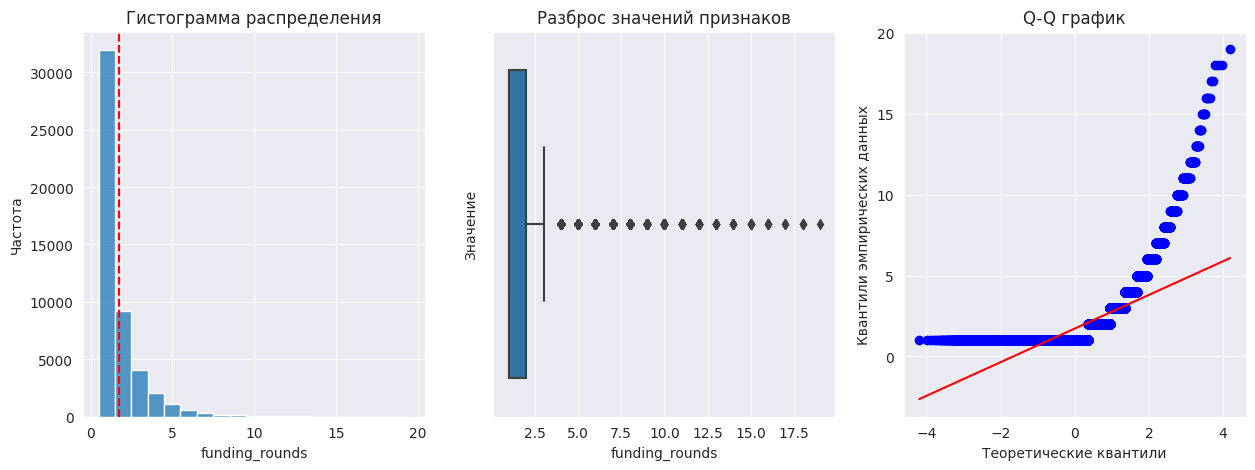

Колонка: 'time_to_first_funding':
count    49584.000000
mean      1063.405776
std       1676.443612
min          0.000000
25%        257.000000
50%        514.000000
75%       1055.250000
max      16708.000000
Name: time_to_first_funding, dtype: float64
False auto


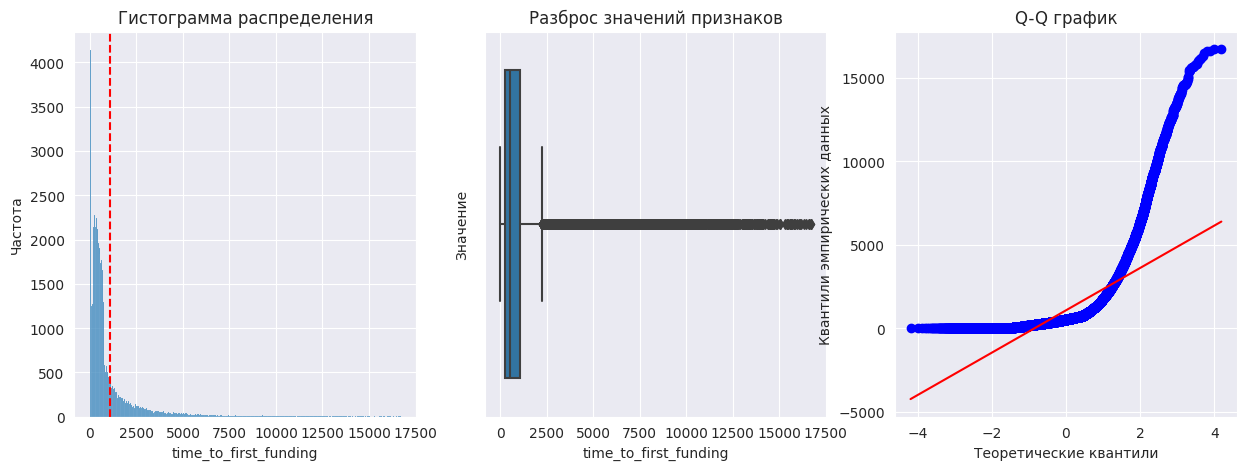

Колонка: 'time_between_funding_rounds':
count    49584.000000
mean       335.728864
std        675.276537
min          0.000000
25%          0.000000
50%          0.000000
75%        403.000000
max      10807.000000
Name: time_between_funding_rounds, dtype: float64
False auto


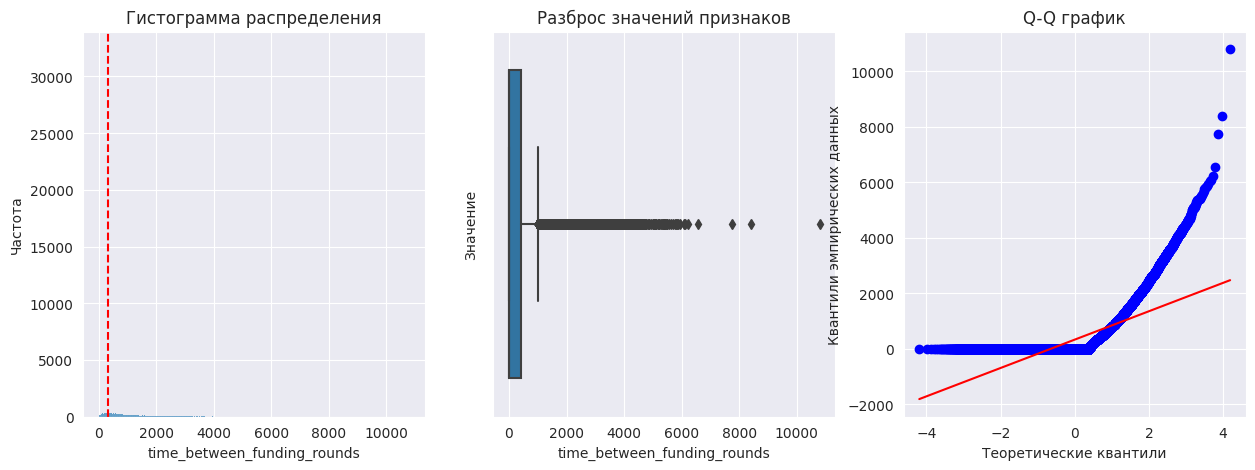

Колонка: 'total_funding_time':
count    49584.000000
mean      1399.134640
std       1805.878706
min          0.000000
25%        367.000000
50%        703.000000
75%       1715.000000
max      16708.000000
Name: total_funding_time, dtype: float64
False auto


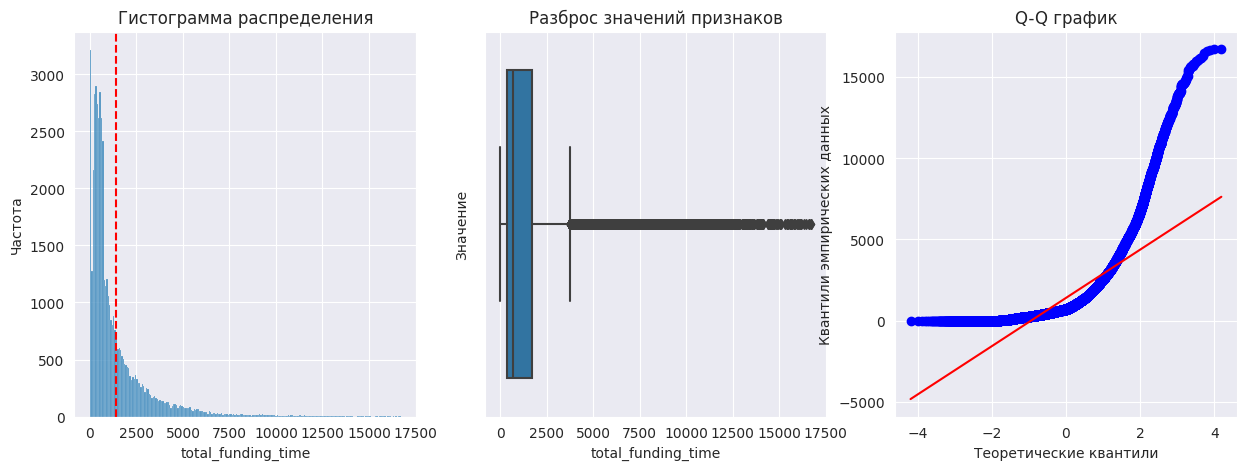

Колонка: 'funding_day':
count    49584.000000
mean       963.976759
std       1520.954891
min          0.000000
25%        286.000000
50%        501.000000
75%        914.500000
max      16708.000000
Name: funding_day, dtype: float64
False auto


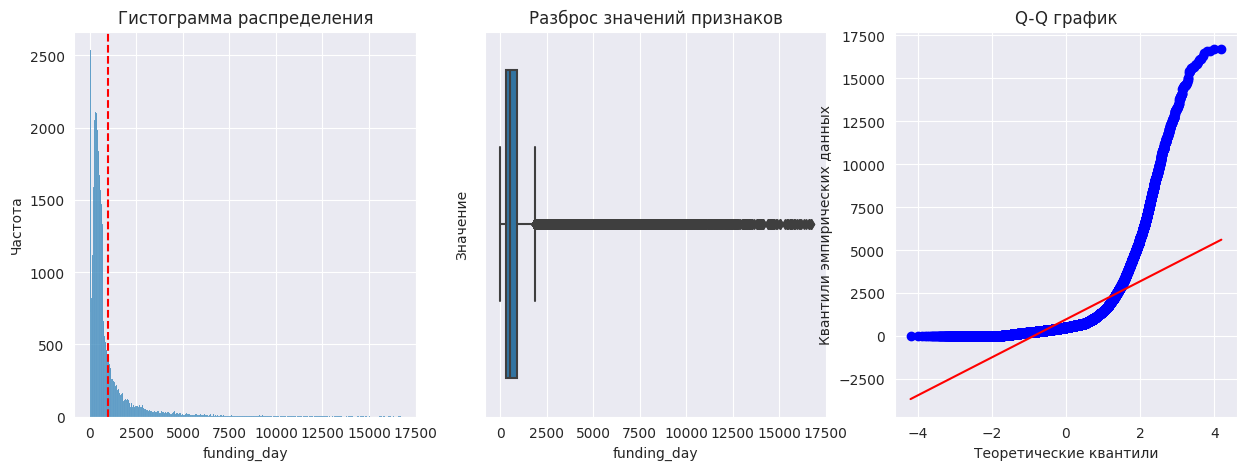

Колонка: 'lifetime':
count    49584.000000
mean      3206.807740
std       2186.005759
min        361.000000
25%       1781.000000
50%       2557.000000
75%       4018.000000
max      17532.000000
Name: lifetime, dtype: float64
False auto


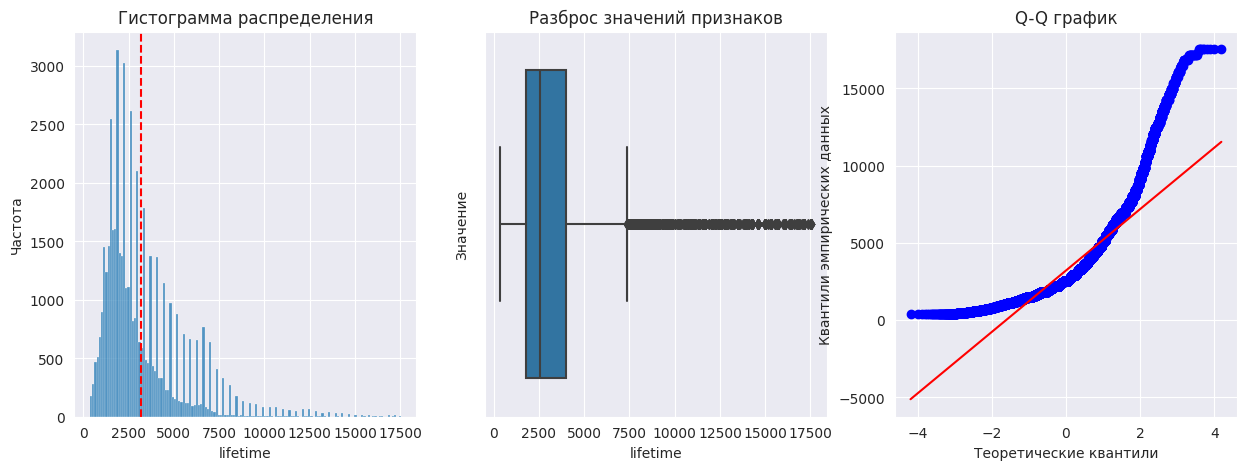

Колонка: 'funding_per_round':
count    4.958400e+04
mean     9.536312e+06
std      7.841147e+07
min      1.000000e+00
25%      4.546485e+05
50%      2.760000e+06
75%      8.000000e+06
max      1.066494e+10
Name: funding_per_round, dtype: float64
False auto


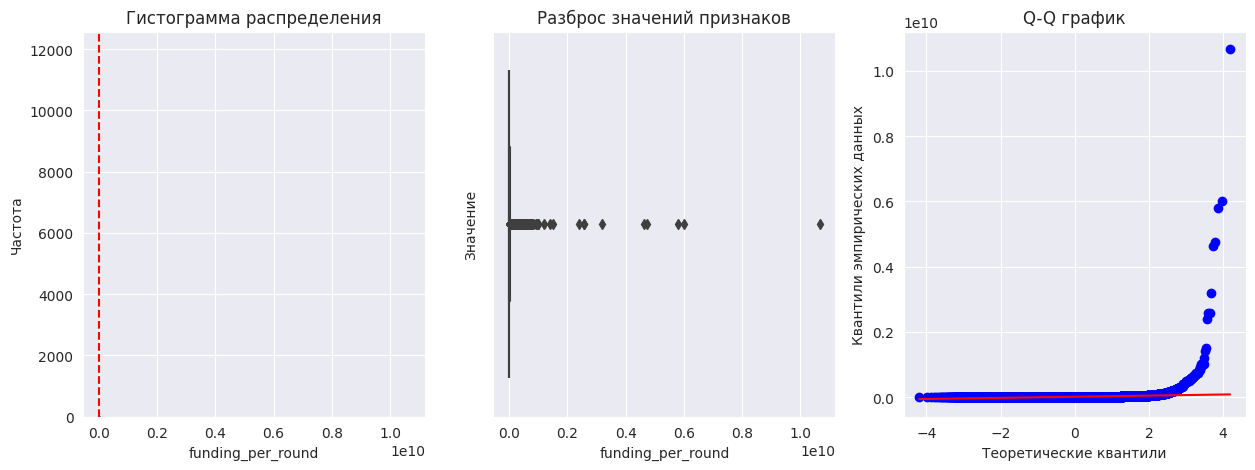

In [120]:
quantitative_info(startups_train_df)

In [121]:
startups_train_df.query("funding_total_usd > 15000000000")

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,time_to_first_funding,time_between_funding_rounds,total_funding_time,funding_day,lifetime,funding_per_round
39452,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,9608,1494,11102,2220.4,12505,6.015901e+09


Такое значение финансирования является аномальным, удалим его.

In [122]:
startups_train_df = startups_train_df.query("funding_total_usd < 15000000000")

Посмотрим на распределение `status`

Колонка: 'status':
count         49583
unique            2
top       operating
freq          44992
Name: status, dtype: object


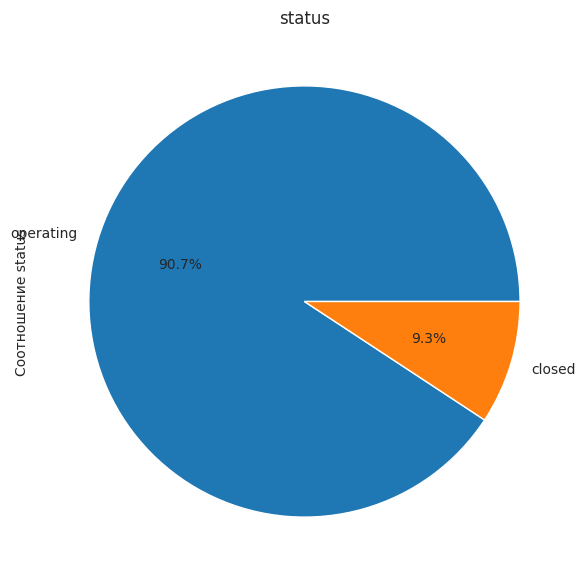

In [123]:
categorical_info(startups_train_df[['status']])

Есть дисбаланс классов, closed меньше чем operating.

Оставим в `category_list` наиболее часто используемую категорию. Составим список наиболее часто используемых категорий:

In [124]:
# Разделение значений в колонке category_list и создание списка категорий
categories = startups_train_df['category_list'].str.split('|').explode()

# Подсчет частоты каждой категории
category_counts = categories.value_counts()

# Выбор 20 наиболее часто используемых категорий
top_200_categories = category_counts.head(200).index.tolist()
top_200_categories

['Software',
 'Mobile',
 'Biotechnology',
 'E-Commerce',
 'Curated Web',
 'Enterprise Software',
 'Social Media',
 'Health Care',
 'Advertising',
 'Games',
 'Internet',
 'SaaS',
 'Health and Wellness',
 'Analytics',
 'Education',
 'Technology',
 'Apps',
 'Finance',
 'Clean Technology',
 'Hardware + Software',
 'Services',
 'Manufacturing',
 'Medical',
 'Security',
 'Marketplaces',
 'Video',
 'Fashion',
 'Information Technology',
 'Cloud Computing',
 'Big Data',
 'Real Estate',
 'Consulting',
 'Entertainment',
 'Travel',
 'Networking',
 'Music',
 'Media',
 'Search',
 'Sales and Marketing',
 'Retail',
 'Social Network Media',
 'Hospitality',
 'News',
 'Financial Services',
 'Startups',
 'Sports',
 'Semiconductors',
 'Web Hosting',
 'Design',
 'FinTech',
 'Messaging',
 'Digital Media',
 'Medical Devices',
 'Web Development',
 'Automotive',
 'Photography',
 'Business Services',
 'Android',
 'Pharmaceuticals',
 'iPhone',
 'Events',
 'Telecommunications',
 'Content',
 'Consumer Electronics',

In [125]:
# Функция для определения наиболее часто используемой категории из списка top_20_categories
def get_top_category(category_list):
    categories = category_list.split('|')
    for category in categories:
        if category in top_200_categories:
            return category
    return 'other'


# Применение функции get_top_category к каждой строке в колонке category_list
startups_train_df['top_category'] = startups_train_df['category_list'].apply(get_top_category)
startups_train_df = startups_train_df.drop(['category_list'], axis=1)
startups_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49583 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            49583 non-null  float64
 1   status                       49583 non-null  object 
 2   country_code                 44378 non-null  object 
 3   state_code                   43184 non-null  object 
 4   region                       43545 non-null  object 
 5   city                         43545 non-null  object 
 6   funding_rounds               49583 non-null  int64  
 7   time_to_first_funding        49583 non-null  int64  
 8   time_between_funding_rounds  49583 non-null  int64  
 9   total_funding_time           49583 non-null  int64  
 10  funding_day                  49583 non-null  float64
 11  lifetime                     49583 non-null  int64  
 12  funding_per_round            49583 non-null  float64
 13  top_category         

В процессе исследовательского анализа, мы нашли аномалии в данных, заменили значения в category_list.

## Обучение модели

Построим матрицу корреляции

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'time_to_first_funding', 'time_between_funding_rounds', 'total_funding_time', 'funding_day', 'lifetime', 'funding_per_round']


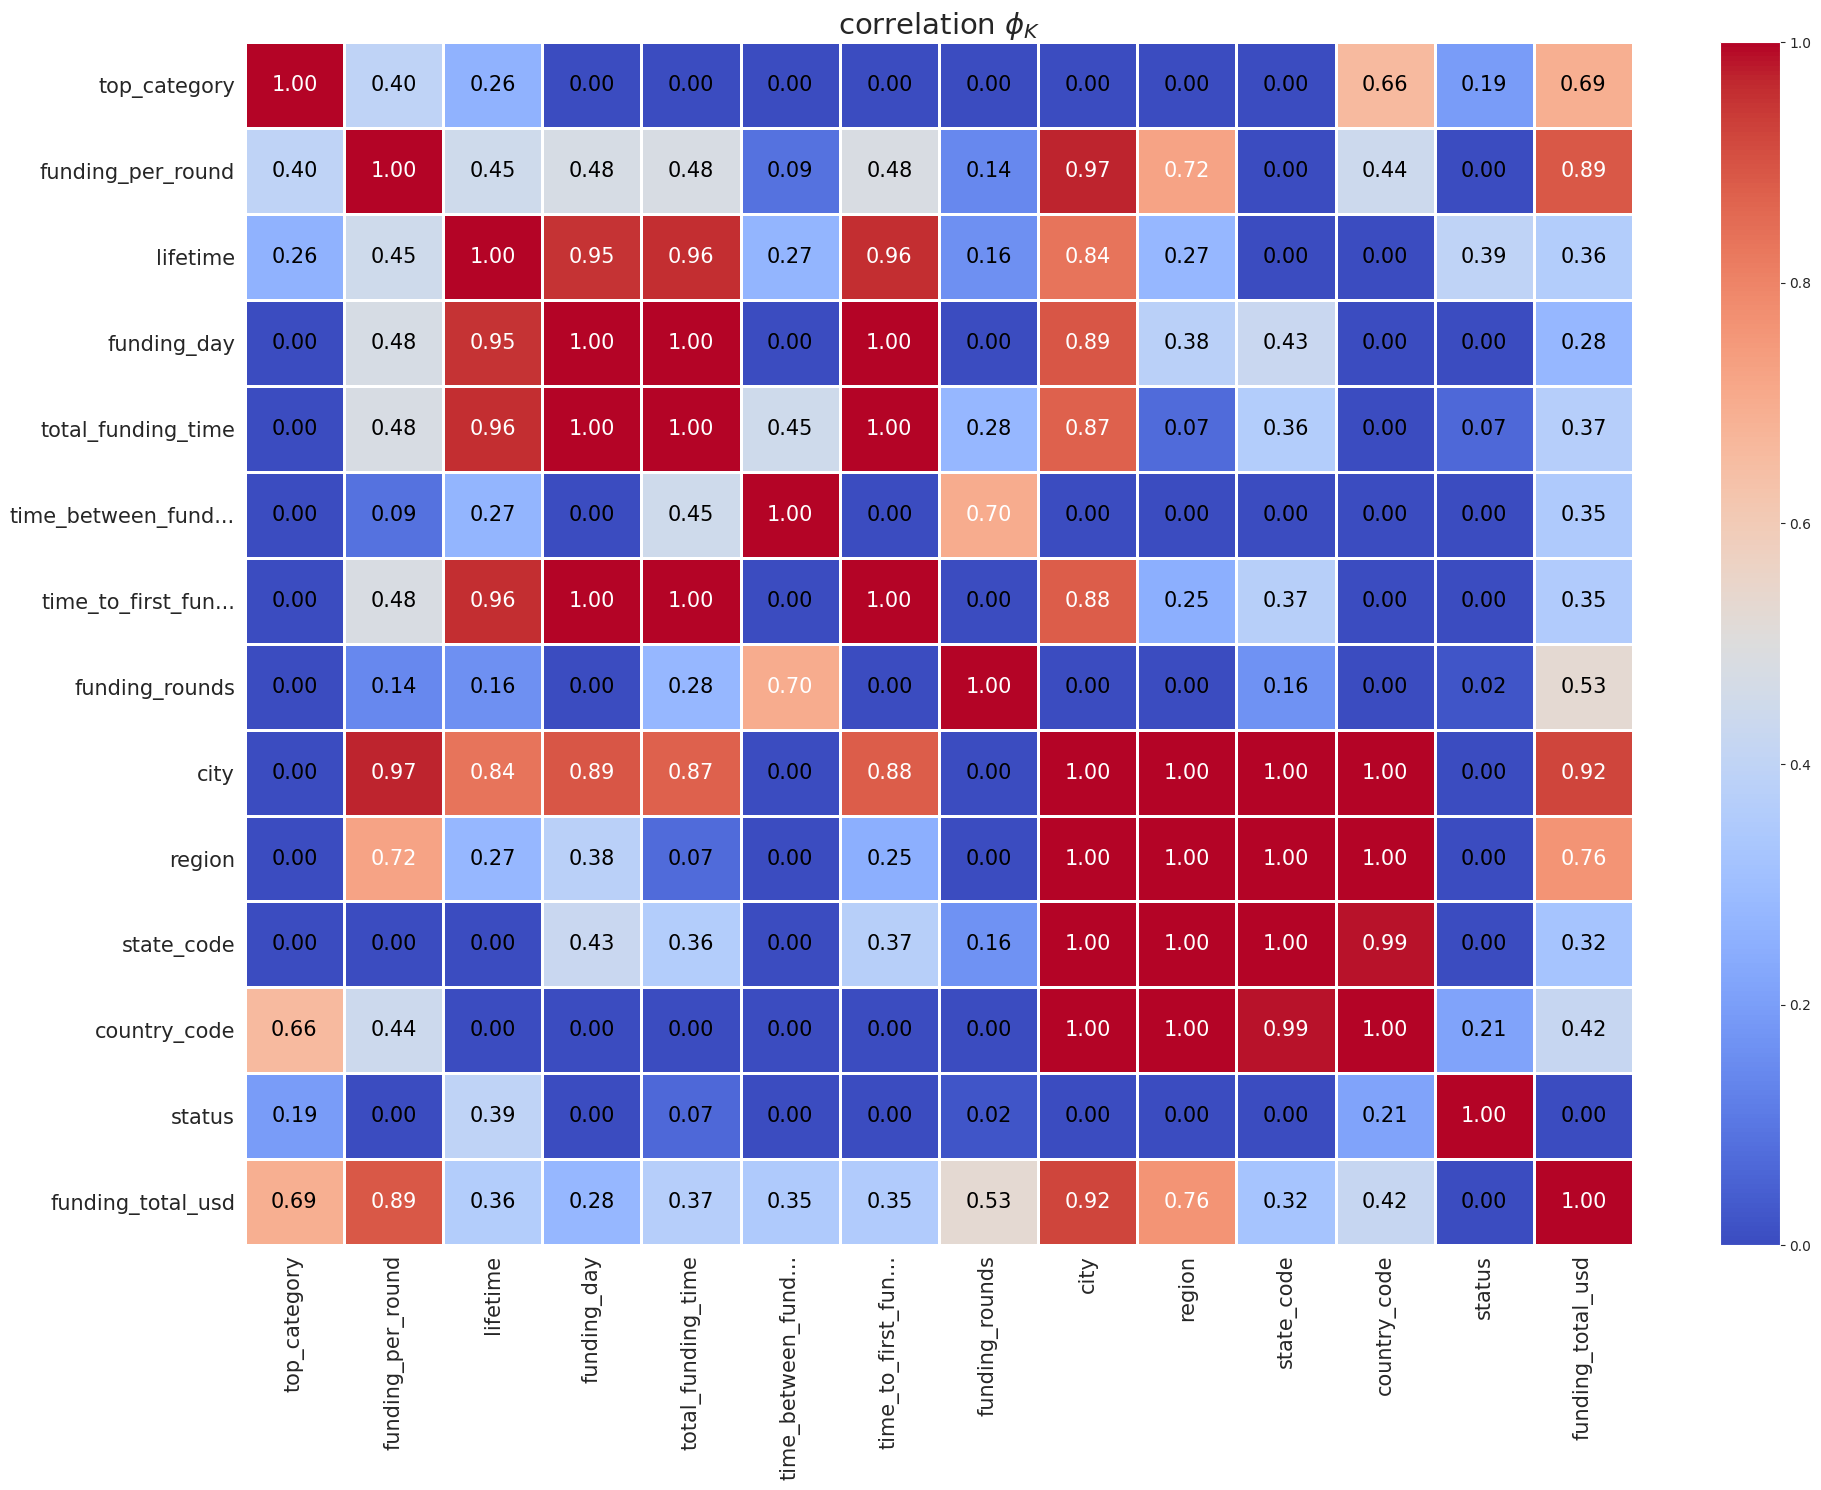

In [126]:
phik_overview = startups_train_df.sample(1000).phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мультиколлинеарность отсутствует между таргетом и входными признаками. Оставим мультиколлинеарность между другими признаками так как будем использовать catboost.

Построим силу связи:

In [127]:
def cheddar_scale(ser):
    for index in ser.index:
        corr = ser[index]
        if 0.1 <= corr <= 0.3:
            coupling_strength = f'слабая ({corr:.3f})'
        elif 0.3 < corr <= 0.5:
            coupling_strength = f'умеренная ({corr:.3f})'
        elif 0.5 < corr <= 0.7:
            coupling_strength = f'заметная ({corr:.3f})'
        elif 0.7 < corr <= 0.9:
            coupling_strength = f'высокая ({corr:.3f})'
        elif 0.9 < corr <= 1:
            coupling_strength = f'весьма высокая ({corr:.3f})'
        else:
            coupling_strength = f'отсутствует ({corr:.3f})'

        print(f'Сила связи между {"status"} и {index}: {coupling_strength}')


cheddar_scale(phik_overview['status'])

Сила связи между status и funding_total_usd: отсутствует (0.000)
Сила связи между status и status: весьма высокая (1.000)
Сила связи между status и country_code: слабая (0.214)
Сила связи между status и state_code: отсутствует (0.000)
Сила связи между status и region: отсутствует (0.000)
Сила связи между status и city: отсутствует (0.000)
Сила связи между status и funding_rounds: отсутствует (0.021)
Сила связи между status и time_to_first_funding: отсутствует (0.000)
Сила связи между status и time_between_funding_rounds: отсутствует (0.000)
Сила связи между status и total_funding_time: отсутствует (0.066)
Сила связи между status и funding_day: отсутствует (0.000)
Сила связи между status и lifetime: умеренная (0.395)
Сила связи между status и funding_per_round: отсутствует (0.000)
Сила связи между status и top_category: слабая (0.192)


Код для обучения:

In [128]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = startups_train_df.drop(['status'], axis=1)
y = startups_train_df['status']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [129]:
def objective_catboost(trial):
    data_preprocessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                                (OneHotEncoder(drop='first', handle_unknown='ignore',
                                                               sparse_output=False),
                                                 make_column_selector(dtype_include='object')),
                                                remainder='passthrough')

    cv_outer = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    param = {
        #'task_type': 'GPU',
        'auto_class_weights': 'Balanced',
        'eval_metric': 'F1',
        'silent': False,
        'random_state': RANDOM_STATE,
        'early_stopping_rounds': 100,
        'depth': trial.suggest_int('depth', 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'random_strength': trial.suggest_float('random_strength',1,20),
        'iterations': trial.suggest_int('iterations', 100, 600),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    # Предварительная обработка данных и модель
    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('resample', SMOTETomek(sampling_strategy='auto', random_state=RANDOM_STATE)),
        ('catboost', CatBoostClassifier(**param))
    ])
    
    # Создаем пользовательскую метрику с pos_label='closed'
    f1_closed = make_scorer(f1_score, average='binary', pos_label='closed')

    return cross_val_score(pipeline, X_train, y_train, cv=cv_outer, scoring=f1_closed).mean()

In [130]:
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective_catboost, n_trials=2)

[I 2024-04-14 04:38:26,555] A new study created in memory with name: no-name-131cfabc-2dd8-456a-ad23-5075126da464


0:	learn: 0.8565918	total: 208ms	remaining: 1m 49s
1:	learn: 0.8751731	total: 420ms	remaining: 1m 50s
2:	learn: 0.8752407	total: 645ms	remaining: 1m 52s
3:	learn: 0.8747113	total: 858ms	remaining: 1m 51s
4:	learn: 0.8602836	total: 1.07s	remaining: 1m 51s
5:	learn: 0.8608527	total: 1.3s	remaining: 1m 52s
6:	learn: 0.8584131	total: 1.51s	remaining: 1m 52s
7:	learn: 0.8589906	total: 1.73s	remaining: 1m 52s
8:	learn: 0.8548126	total: 1.97s	remaining: 1m 53s
9:	learn: 0.8584927	total: 2.2s	remaining: 1m 53s
10:	learn: 0.8612281	total: 2.2s	remaining: 1m 53s
11:	learn: 0.8616855	total: 5.49s	remaining: 4m 16s
12:	learn: 0.8610174	total: 8.78s	remaining: 6m 15s
13:	learn: 0.8597204	total: 8.98s	remaining: 5m 53s
14:	learn: 0.8595263	total: 9.2s	remaining: 5m 35s
15:	learn: 0.8569804	total: 9.42s	remaining: 5m 20s
16:	learn: 0.8580220	total: 9.63s	remaining: 5m 6s
17:	learn: 0.8575606	total: 9.85s	remaining: 4m 54s
18:	learn: 0.8591586	total: 10.1s	remaining: 4m 43s
19:	learn: 0.8569363	total:

[I 2024-04-14 05:08:29,428] Trial 0 finished with value: 0.6558748785100088 and parameters: {'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'random_strength': 18.482767713155006, 'iterations': 526, 'l2_leaf_reg': 8.117739140003733, 'learning_rate': 0.005664199875193011, 'subsample': 0.1750159424271094}. Best is trial 0 with value: 0.6558748785100088.


0:	learn: 0.8547540	total: 12.8ms	remaining: 6.26s
1:	learn: 0.8574374	total: 25.7ms	remaining: 6.29s
2:	learn: 0.8588458	total: 38.5ms	remaining: 6.26s
3:	learn: 0.8630641	total: 52.7ms	remaining: 6.42s
4:	learn: 0.8706835	total: 65.7ms	remaining: 6.39s
5:	learn: 0.8681587	total: 78.7ms	remaining: 6.36s
6:	learn: 0.8756394	total: 92.4ms	remaining: 6.39s
7:	learn: 0.8870087	total: 106ms	remaining: 6.41s
8:	learn: 0.8908939	total: 119ms	remaining: 6.39s
9:	learn: 0.8979477	total: 132ms	remaining: 6.36s
10:	learn: 0.9070047	total: 146ms	remaining: 6.35s
11:	learn: 0.9076217	total: 159ms	remaining: 6.33s
12:	learn: 0.9080749	total: 172ms	remaining: 6.32s
13:	learn: 0.9077935	total: 185ms	remaining: 6.3s
14:	learn: 0.9172590	total: 198ms	remaining: 6.28s
15:	learn: 0.9225145	total: 213ms	remaining: 6.32s
16:	learn: 0.9228939	total: 226ms	remaining: 6.31s
17:	learn: 0.9223968	total: 241ms	remaining: 6.33s
18:	learn: 0.9240292	total: 255ms	remaining: 6.33s
19:	learn: 0.9251376	total: 268ms	r

[I 2024-04-14 05:28:52,581] Trial 1 finished with value: 0.9442858940475667 and parameters: {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_strength': 7.091563810081899, 'iterations': 491, 'l2_leaf_reg': 5.409959894347784, 'learning_rate': 0.09330156945356155, 'bagging_temperature': 0.813157400627823}. Best is trial 1 with value: 0.9442858940475667.


In [131]:
print("Лучшие параметры: ", catboost_study.best_trial.params)
print("Лучшее значение F1: ", catboost_study.best_trial.value)

Лучшие параметры:  {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_strength': 7.091563810081899, 'iterations': 491, 'l2_leaf_reg': 5.409959894347784, 'learning_rate': 0.09330156945356155, 'bagging_temperature': 0.813157400627823}
Лучшее значение F1:  0.9442858940475667


In [132]:
visualization.plot_param_importances(catboost_study)

In [133]:
visualization.plot_optimization_history(catboost_study)

In [134]:
data_preprocessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include='number')),
                                            (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                                             make_column_selector(dtype_include='object')),
                                            remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('resample', SMOTETomek(sampling_strategy=0.7, random_state=RANDOM_STATE)),
    ('catboost', CatBoostClassifier(**catboost_study.best_trial.params))
])

pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

print('F1:', f1_score(y_test, prediction, average='binary', pos_label='closed'))
print(classification_report(y_test, prediction))

0:	learn: 0.6352970	total: 13ms	remaining: 6.37s
1:	learn: 0.5891234	total: 26.3ms	remaining: 6.42s
2:	learn: 0.5310296	total: 38.9ms	remaining: 6.32s
3:	learn: 0.5034299	total: 51.1ms	remaining: 6.22s
4:	learn: 0.4816568	total: 63.6ms	remaining: 6.18s
5:	learn: 0.4605327	total: 75.9ms	remaining: 6.13s
6:	learn: 0.4101407	total: 89.2ms	remaining: 6.17s
7:	learn: 0.3751448	total: 102ms	remaining: 6.18s
8:	learn: 0.3561407	total: 115ms	remaining: 6.17s
9:	learn: 0.3419113	total: 128ms	remaining: 6.15s
10:	learn: 0.3274503	total: 141ms	remaining: 6.13s
11:	learn: 0.3184713	total: 153ms	remaining: 6.11s
12:	learn: 0.3020796	total: 167ms	remaining: 6.12s
13:	learn: 0.2903338	total: 180ms	remaining: 6.12s
14:	learn: 0.2713739	total: 193ms	remaining: 6.12s
15:	learn: 0.2632111	total: 206ms	remaining: 6.11s
16:	learn: 0.2568390	total: 219ms	remaining: 6.11s
17:	learn: 0.2549409	total: 233ms	remaining: 6.12s
18:	learn: 0.2488364	total: 247ms	remaining: 6.13s
19:	learn: 0.2445550	total: 262ms	re

Подготовим тестовые данные

In [135]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in date_columns:
    startups_test_df[col] = pd.to_datetime(startups_test_df[col])

startups_test_df.closed_at = pd.to_datetime('2018-01-01')
add_new_time_columns(startups_test_df)
set_missed(startups_test_df)
isna_rate(startups_test_df)

startups_test_df['top_category'] = startups_test_df['category_list'].apply(get_top_category)
startups_test_df = startups_test_df.drop(['category_list'], axis=1)

startups_test_df['funding_per_round'] = (
            startups_test_df['funding_total_usd'] / startups_test_df['funding_rounds'])

startups_test_df

,Процент пропусков
state_code,12.86
region,12.06
city,12.04
country_code,10.48


,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,time_to_first_funding,time_between_funding_rounds,total_funding_time,funding_day,lifetime,top_category,funding_per_round
0,Crystalsol,2.819200e+06,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,2018-01-01,395,0,395,395.00,3501,Clean Technology,2.819200e+06
1,JBI Fish & Wings,6.566104e+06,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2018-01-01,3,0,3,3.00,2717,Hospitality,6.566104e+06
2,COINPLUS,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,2018-01-01,-32,126,94,47.00,1295,Finance,2.141285e+05
3,Imagine Communications,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,2018-01-01,0,1935,1935,483.75,4748,Software,8.675000e+06
4,DNA13,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,2018-01-01,2318,0,2318,2318.00,6209,Software,4.530000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,Jymob,2.800000e+04,USA,CA,SF Bay Area,Sunnyvale,1,2011-12-06,2012-07-01,2012-07-01,2018-01-01,208,0,208,208.00,2218,Recruiting,2.800000e+04
13207,GlobaTrek,6.566104e+06,USA,CA,SF Bay Area,Mountain View,1,2012-01-01,2013-10-01,2013-10-01,2018-01-01,639,0,639,639.00,2192,Software,6.566104e+06
13208,Inkd.com,5.600000e+06,USA,WA,Seattle,Seattle,3,2010-01-01,2008-09-01,2011-06-28,2018-01-01,-487,1030,543,181.00,2922,Design,1.866667e+06
13209,AdWill,1.500000e+05,USA,NY,New York City,New York,2,2012-12-04,2014-09-27,2014-11-04,2018-01-01,662,38,700,350.00,1854,Mobile,7.500000e+04


Спрогнозируем `status`:

In [136]:
prediction = pipeline.predict(startups_test_df)
startups_test_df['status'] = prediction
startups_test_df

,name,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,time_to_first_funding,time_between_funding_rounds,total_funding_time,funding_day,lifetime,top_category,funding_per_round,status
0,Crystalsol,2.819200e+06,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,2018-01-01,395,0,395,395.00,3501,Clean Technology,2.819200e+06,operating
1,JBI Fish & Wings,6.566104e+06,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2018-01-01,3,0,3,3.00,2717,Hospitality,6.566104e+06,operating
2,COINPLUS,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,2018-01-01,-32,126,94,47.00,1295,Finance,2.141285e+05,operating
3,Imagine Communications,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,2018-01-01,0,1935,1935,483.75,4748,Software,8.675000e+06,operating
4,DNA13,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,2018-01-01,2318,0,2318,2318.00,6209,Software,4.530000e+06,operating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13206,Jymob,2.800000e+04,USA,CA,SF Bay Area,Sunnyvale,1,2011-12-06,2012-07-01,2012-07-01,2018-01-01,208,0,208,208.00,2218,Recruiting,2.800000e+04,operating
13207,GlobaTrek,6.566104e+06,USA,CA,SF Bay Area,Mountain View,1,2012-01-01,2013-10-01,2013-10-01,2018-01-01,639,0,639,639.00,2192,Software,6.566104e+06,operating
13208,Inkd.com,5.600000e+06,USA,WA,Seattle,Seattle,3,2010-01-01,2008-09-01,2011-06-28,2018-01-01,-487,1030,543,181.00,2922,Design,1.866667e+06,operating
13209,AdWill,1.500000e+05,USA,NY,New York City,New York,2,2012-12-04,2014-09-27,2014-11-04,2018-01-01,662,38,700,350.00,1854,Mobile,7.500000e+04,operating


Сохраним csv файл с результатами:

In [137]:
new_df = startups_test_df[['name', 'status']]
new_df.to_csv('result.csv', sep=',', index=False)

Вычислим важность параметров:

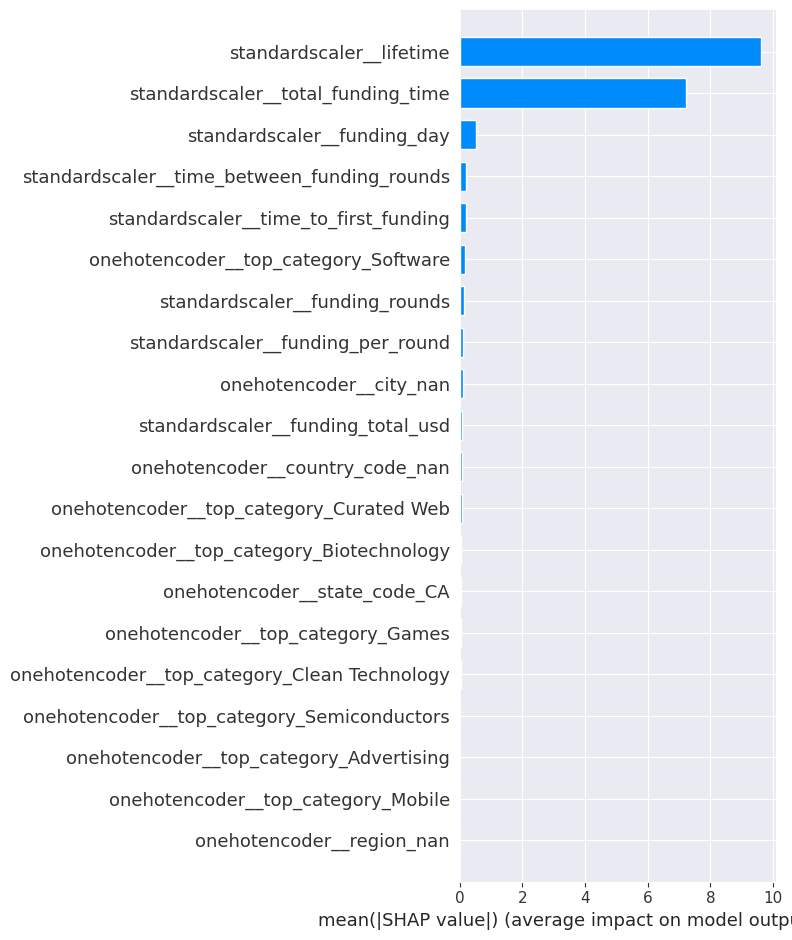

In [138]:
model = pipeline.named_steps['catboost']
preprocessor_task = pipeline.named_steps['preprocessor']
transformed = preprocessor_task.transform(startups_test_df)

feature_importances = pd.DataFrame(
    {
        'Feature': preprocessor_task.get_feature_names_out(),
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
feature_importances

# Вычисление SHAP-значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(transformed)

# Визуализация важности признаков
shap.summary_plot(shap_values, transformed, plot_type="bar", feature_names=preprocessor_task.get_feature_names_out())

## Общий вывод

Требовалось подготовить прототип модели машинного обучения, которая должна предсказать успешность стартапа (закроется или нет). Была обучена модель с использованием `catboost` и `optana`

Для это были выполнены следующие действия:

- загрузить библиотеки;
- открыть файлы с данными;
- выполнить предобработку данных:
    - изменить типы данных там где это необходимо;
    - проверить и устранить дубликаты;
    - проверить наличие пропущенных значений;  
- провести исследовательский анализ данных:
    - найти аномальные и выдающиеся значения;
    - выбрать данные для обучения.
- выполнить корреляционный анализ;
- используя пайплайны найти лучшие гиперпараметры модели;
- выполнить анализ важности признаков;
- выбрать лучшую модель и проверить её на тестовой выборке;

С точки зрения модели для предсказания уровня удовлетворённости наиболее важными признаками для прогноза закрытия стартапа являются:
- Время жизни стартапа
- Время от последнего раунда финансирования до даты основания, в днях
- Количество дней на раунд

Метрика качества модели `F1`: `0.95`